<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [1]:
import numpy as np

from tqdm import tqdm_notebook

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F
from torchsummary import summary

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

In [2]:
torch.cuda.empty_cache()

In [3]:
!nvidia-smi

Sun Nov 14 23:50:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [4]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

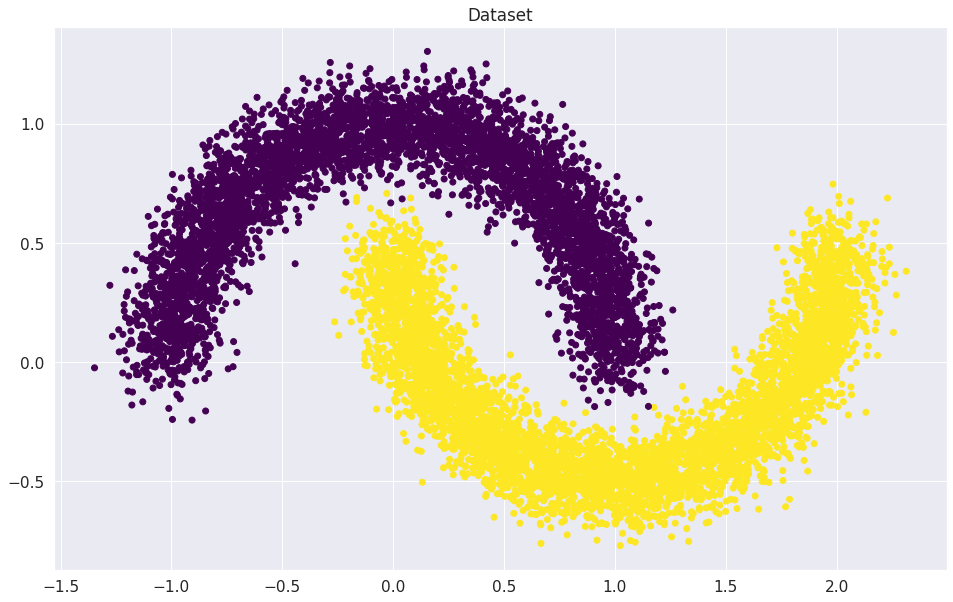

In [5]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [7]:
X_train_t =  torch.FloatTensor(X_train) # YOUR CODE GOES HERE
y_train_t = torch.FloatTensor(y_train) # YOUR CODE GOES HERE
X_val_t = torch.FloatTensor(X_val) # YOUR CODE GOES HERE
y_val_t =  torch.FloatTensor(y_val) # YOUR CODE GOES HERE

Создаем `Dataset` и `DataLoader`. 

In [8]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [9]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features)) # YOUR CODE GOES HERE
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features)) # YOUR CODE GOES HERE

    def forward(self, x):
        x = x @ self.weights   # YOUR CODE GOES HERE
        if self.bias:
            x += self.bias_term # YOUR CODE GOES HERE
        return x

In [10]:
linear_regression = LinearRegression(2, 1).cuda()
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

In [11]:
print(sum(i.numel() for i in linear_regression.parameters() if i.requires_grad))

3


**Вопрос 1.** Сколько обучаемых параметров у получившейся модели?

In [12]:
3

3

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [13]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in tqdm_notebook(range(max_epochs)):
    for it, (X_batch, y_batch) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        outp = linear_regression(X_batch.cuda()) # YOUR CODE. Use linear_regression to get outputs
        loss = loss_function(outp, torch.unsqueeze(y_batch, 1).cuda())  # YOUR CODE. Compute loss
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = torch.sigmoid(outp) # YOUR CODE. Compute probabilities
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch.cuda()).type(torch.float32).sum() / y_batch.cuda().size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/59 [00:00<?, ?it/s]

Iteration: 0
Batch accuracy: 0.3828125


  0%|          | 0/59 [00:00<?, ?it/s]

Iteration: 100
Batch accuracy: 0.8515625


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Iteration: 200
Batch accuracy: 0.875


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Iteration: 300
Batch accuracy: 0.921875


  0%|          | 0/59 [00:00<?, ?it/s]

Iteration: 400
Batch accuracy: 0.8984375


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Iteration: 500
Batch accuracy: 0.921875

Iteration: 519.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:**

In [ ]:
519

### Визуализируем результаты

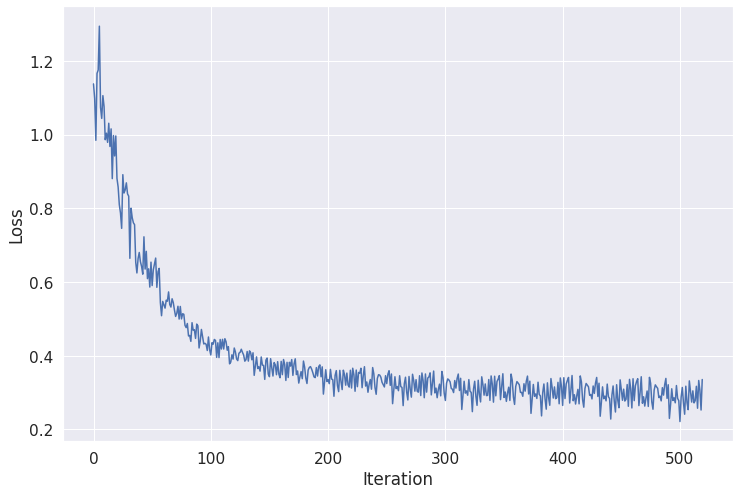

In [15]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

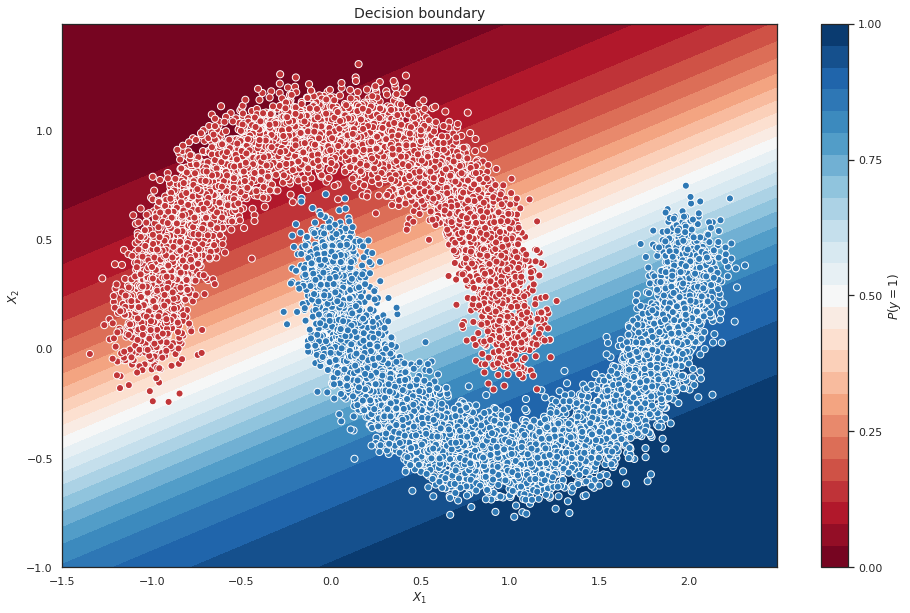

In [16]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch.cuda()).cuda().reshape(xx.shape))
    probs = probs.cpu().numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [17]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        prob = torch.sigmoid(model(x_batch.cuda()).cuda())
        preds = (prob > 0.5).type(torch.long) #YOUR CODE. Compute predictions
        predictions = np.hstack((predictions, preds.cpu().numpy().flatten()))
    return predictions.flatten()

In [18]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_val_t, predict(val_dataloader, linear_regression)))
# YOUR CODE. Compute total accuracy

0.8804


**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 

In [ ]:
0.8804

In [20]:
torch.cuda.empty_cache()
!nvidia-smi

Sun Nov 14 23:50:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    61W / 149W |    533MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [21]:
import os
from torchvision.datasets import MNIST
import torchvision.transforms as tfs

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
batch_size = 128
features = 784
classes = 10

train_dataset = MNIST(root, train=True, transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader =  DataLoader(train_dataset, batch_size=batch_size, drop_last=True)  # YOUR CODE GOES HERE
valid_dataloader =  DataLoader(val_dataset, batch_size=batch_size, drop_last=True)   # YOUR CODE GOES HERE

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [22]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [23]:
activation = nn.ELU

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(features, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, classes),
    #YOUR CODE. Add layers to your sequential class
)

In [24]:
summary(model.cuda(), (features,), batch_size=128)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [128, 784]               0
            Linear-2                 [128, 128]         100,480
               ELU-3                 [128, 128]               0
            Linear-4                 [128, 128]          16,512
               ELU-5                 [128, 128]               0
            Linear-6                  [128, 10]           1,290
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.38
Forward/backward pass size (MB): 1.28
Params size (MB): 0.45
Estimated Total Size (MB): 2.11
----------------------------------------------------------------


In [25]:
criterion = torch.nn.CrossEntropyLoss() #YOUR CODE. Select a loss function
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ELU(alpha=1.0)
  (3): Linear(in_features=128, out_features=128, bias=True)
  (4): ELU(alpha=1.0)
  (5): Linear(in_features=128, out_features=10, bias=True)
)

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [27]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in tqdm_notebook(range(max_epochs)):
    for k, dataloader in tqdm_notebook(loaders.items()):
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                 model.train()
                 optimizer.zero_grad()
                 outp = model(x_batch.to(device))
                 # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
            else:
                 model.eval()
                 with torch.no_grad():
                   outp = model(x_batch.to(device))
                 # YOUR CODE. Set model to ``eval`` mode and calculate outputs
            preds = outp.argmax(-1)
            correct = (preds.cpu() == y_batch).numpy().sum() # YOUR CODE GOES HERE
            all = len(x_batch) # YOUR CODE GOES HERE
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp.cpu(), y_batch)
                loss.backward()
                optimizer.step()
                # YOUR CODE. Calculate gradients and make a step of your optimizer
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.87890625
Loader: valid. Accuracy: 0.9305889423076923


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 2
Loader: train. Accuracy: 0.9418736645299145
Loader: valid. Accuracy: 0.9505208333333334


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 3
Loader: train. Accuracy: 0.9587840544871795
Loader: valid. Accuracy: 0.9567307692307693


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 4
Loader: train. Accuracy: 0.9688000801282052
Loader: valid. Accuracy: 0.9620392628205128


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 5
Loader: train. Accuracy: 0.9754607371794872
Loader: valid. Accuracy: 0.9636418269230769


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 6
Loader: train. Accuracy: 0.9793002136752137
Loader: valid. Accuracy: 0.9591346153846154


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 7
Loader: train. Accuracy: 0.9831563835470085
Loader: valid. Accuracy: 0.9627403846153846


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 8
Loader: train. Accuracy: 0.9844751602564102
Loader: valid. Accuracy: 0.9599358974358975


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 9
Loader: train. Accuracy: 0.9859441773504274
Loader: valid. Accuracy: 0.9618389423076923


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 10
Loader: train. Accuracy: 0.9869791666666666
Loader: valid. Accuracy: 0.9649439102564102


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [28]:
elu_accuracy = accuracy["valid"]

In [29]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)
#arr = [None, nn.ReLU, nn.LeakyReLU, nn.ELU]

def test_activation_function(activation):

    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(features, 128),
        activation(),
        nn.Linear(128, 128),
        activation(),
        nn.Linear(128, classes),
        #YOUR CODE. Add layers to your sequential class
    )
    torch.cuda.empty_cache()
    model.cuda()
    criterion = torch.nn.CrossEntropyLoss() #YOUR CODE. Select a loss function
    optimizer = torch.optim.Adam(model.parameters())

    loaders = {"train": train_dataloader, "valid": valid_dataloader}

    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    for epoch in tqdm_notebook(range(max_epochs)):
        for k, dataloader in tqdm_notebook(loaders.items()):
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch.to(device))
                else:
                    model.eval()
                    with torch.no_grad():
                      outp = model(x_batch.to(device))
                preds = outp.argmax(-1)
                correct = (preds.cpu() == y_batch).numpy().sum()
                all = len(x_batch)
                epoch_correct += correct.item()
                epoch_all += all
                if k == "train":
                    loss = criterion(outp.cpu(), y_batch)
                    loss.backward()
                    optimizer.step()
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)

    return accuracy

In [30]:
plain_accuracy = test_activation_function(Identical)["valid"]
relu_accuracy = test_activation_function(nn.ReLU)["valid"] #YOUR CODE
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)["valid"] #YOUR CODE

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.8643663194444444
Loader: valid. Accuracy: 0.8851161858974359


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 2
Loader: train. Accuracy: 0.8956163194444444
Loader: valid. Accuracy: 0.8966346153846154


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 3
Loader: train. Accuracy: 0.8999232104700855
Loader: valid. Accuracy: 0.8967347756410257


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 4
Loader: train. Accuracy: 0.9025607638888888
Loader: valid. Accuracy: 0.8998397435897436


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 5
Loader: train. Accuracy: 0.9039797008547008
Loader: valid. Accuracy: 0.8995392628205128


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 6
Loader: train. Accuracy: 0.905098157051282
Loader: valid. Accuracy: 0.899238782051282


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 7
Loader: train. Accuracy: 0.9066339476495726
Loader: valid. Accuracy: 0.8997395833333334


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 8
Loader: train. Accuracy: 0.9079193376068376
Loader: valid. Accuracy: 0.9004407051282052


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 9
Loader: train. Accuracy: 0.9089376335470085
Loader: valid. Accuracy: 0.9017427884615384


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 10
Loader: train. Accuracy: 0.9097222222222222
Loader: valid. Accuracy: 0.9021434294871795


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.8641326121794872
Loader: valid. Accuracy: 0.9229767628205128


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 2
Loader: train. Accuracy: 0.9330929487179487
Loader: valid. Accuracy: 0.9488181089743589


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 3
Loader: train. Accuracy: 0.9519230769230769
Loader: valid. Accuracy: 0.9552283653846154


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 4
Loader: train. Accuracy: 0.9619224091880342
Loader: valid. Accuracy: 0.9596354166666666


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 5
Loader: train. Accuracy: 0.9684328258547008
Loader: valid. Accuracy: 0.9593349358974359


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 6
Loader: train. Accuracy: 0.9732238247863247
Loader: valid. Accuracy: 0.9616386217948718


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 7
Loader: train. Accuracy: 0.9764122596153846
Loader: valid. Accuracy: 0.9598357371794872


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 8
Loader: train. Accuracy: 0.9788661858974359
Loader: valid. Accuracy: 0.9645432692307693


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 9
Loader: train. Accuracy: 0.9820212339743589
Loader: valid. Accuracy: 0.9676482371794872


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 10
Loader: train. Accuracy: 0.9830395299145299
Loader: valid. Accuracy: 0.9675480769230769


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.8695412660256411
Loader: valid. Accuracy: 0.9305889423076923


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 2
Loader: train. Accuracy: 0.9373998397435898
Loader: valid. Accuracy: 0.9512219551282052


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 3
Loader: train. Accuracy: 0.9554787660256411
Loader: valid. Accuracy: 0.956229967948718


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 4
Loader: train. Accuracy: 0.9652110042735043
Loader: valid. Accuracy: 0.960136217948718


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 5
Loader: train. Accuracy: 0.9716045673076923
Loader: valid. Accuracy: 0.9614383012820513


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 6
Loader: train. Accuracy: 0.9750434027777778
Loader: valid. Accuracy: 0.9673477564102564


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 7
Loader: train. Accuracy: 0.978248530982906
Loader: valid. Accuracy: 0.9662459935897436


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 8
Loader: train. Accuracy: 0.9798844818376068
Loader: valid. Accuracy: 0.9671474358974359


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 9
Loader: train. Accuracy: 0.9816539797008547
Loader: valid. Accuracy: 0.9639423076923077


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 10
Loader: train. Accuracy: 0.9836738782051282
Loader: valid. Accuracy: 0.9599358974358975


### Accuracy
Построим график accuracy/epoch для каждой функции активации.

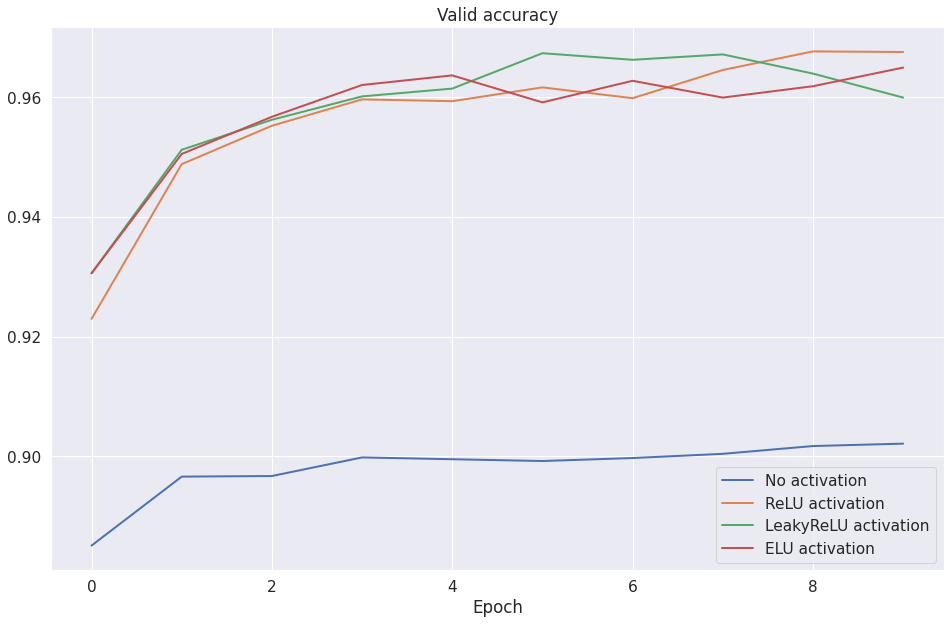

In [31]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

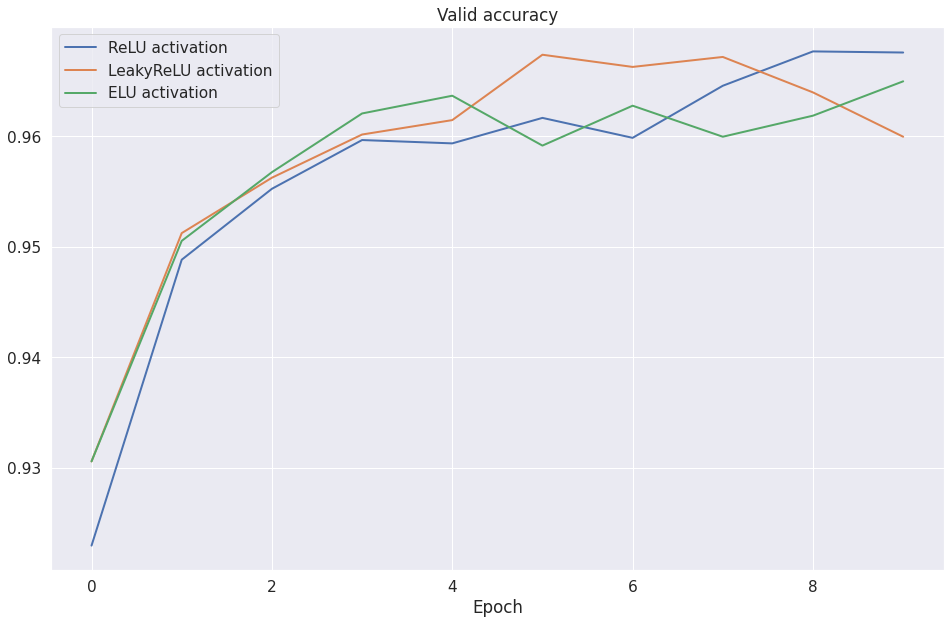

In [32]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:**

ReLu

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [35]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2021-11-15 00:00:31--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 144.76.208.75
Connecting to img.the-village.kz (img.the-village.kz)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg [following]
--2021-11-15 00:00:31--  https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village-kz.com (img.the-village-kz.com)... 144.76.208.75
Connecting to img.the-village-kz.com (img.the-village-kz.com)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K  --.-KB/s    in 0.02s   

2021-11-15 00:00:31 (1.90 MB/s) - ‘sample_photo.jpg’ saved [49337/

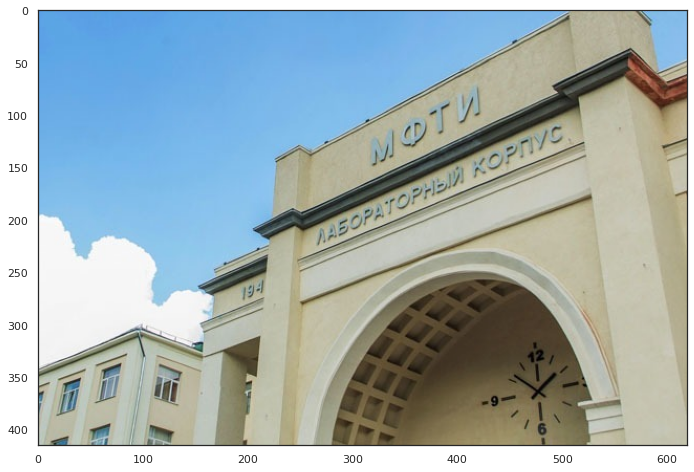

In [36]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [37]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, 1, 0],
[1, -4, 1],
[0, 1, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


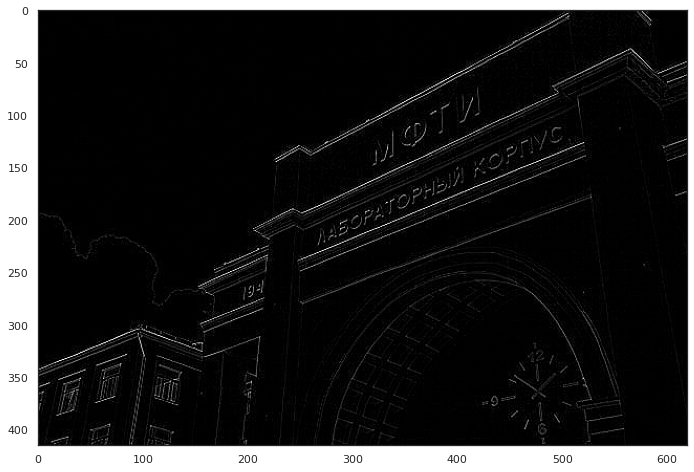

In [38]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:**

A) 3   Б) 5   В) 4   Г) 6   Д) 2   Е) 1

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [40]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(2) #YOUR CODE
        self.conv2 = nn.Conv2d(6, 16, 3) #YOUR CODE
        self.pool2 = nn.MaxPool2d(2) #YOUR CODE
        self.fc1 = nn.Linear(16*5*5, 120) #YOUR CODE  
        self.fc2 = nn.Linear(120, 84) #YOUR CODE
        self.fc3 = nn.Linear(84, 10) #YOUR CODE

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x))) #YOUR CODE. Apply layers created in __init__. 
        x = self.pool2(F.relu(self.conv2(x)))
        #print(x.shape)
        x = nn.Flatten()(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [41]:
model = LeNet().to(device)

In [43]:
batch = []


batch = next(iter(train_dataloader))

model.forward(torch.FloatTensor(batch[0]).cuda())

tensor([[ 0.0667, -0.0302,  0.0076,  ...,  0.0703, -0.0413,  0.0520],
        [ 0.0766, -0.0189, -0.0415,  ...,  0.0734, -0.0617,  0.0334],
        [ 0.0850, -0.0228, -0.0169,  ...,  0.0959, -0.0468,  0.0295],
        ...,
        [ 0.0690, -0.0246, -0.0133,  ...,  0.0530, -0.0569,  0.0504],
        [ 0.0820, -0.0299, -0.0040,  ...,  0.0551, -0.0492,  0.0523],
        [ 0.0776, -0.0109, -0.0210,  ...,  0.0635, -0.0456,  0.0376]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [42]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [44]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in tqdm_notebook(range(max_epochs)):
    for k, dataloader in tqdm_notebook(loaders.items()):
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                 model.train()
                 optimizer.zero_grad()
                 outp = model(x_batch.to(device))
                 # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
            else:
                 model.eval()
                 with torch.no_grad():
                   outp = model(x_batch.to(device))
                 # YOUR CODE. Set model to ``eval`` mode and calculate outputs
            preds = outp.argmax(-1)
            correct = (preds.cpu() == y_batch).numpy().sum() # YOUR CODE GOES HERE
            all = len(x_batch) # YOUR CODE GOES HERE
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp.cpu(), y_batch)
                loss.backward()
                optimizer.step()
                # YOUR CODE. Calculate gradients and make a step of your optimizer
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.8745993589743589
Loader: valid. Accuracy: 0.9697516025641025


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 2
Loader: train. Accuracy: 0.9680989583333334
Loader: valid. Accuracy: 0.9777644230769231


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 3
Loader: train. Accuracy: 0.9778478899572649
Loader: valid. Accuracy: 0.9821714743589743


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 4
Loader: train. Accuracy: 0.9831063034188035
Loader: valid. Accuracy: 0.9850761217948718


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 5
Loader: train. Accuracy: 0.9865117521367521
Loader: valid. Accuracy: 0.9856770833333334


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 6
Loader: train. Accuracy: 0.9886651976495726
Loader: valid. Accuracy: 0.9864783653846154


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 7
Loader: train. Accuracy: 0.9907017895299145
Loader: valid. Accuracy: 0.9861778846153846


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 8
Loader: train. Accuracy: 0.9924712873931624
Loader: valid. Accuracy: 0.9859775641025641


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 9
Loader: train. Accuracy: 0.9935396634615384
Loader: valid. Accuracy: 0.9858774038461539


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 10
Loader: train. Accuracy: 0.9940404647435898
Loader: valid. Accuracy: 0.9853766025641025


In [45]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

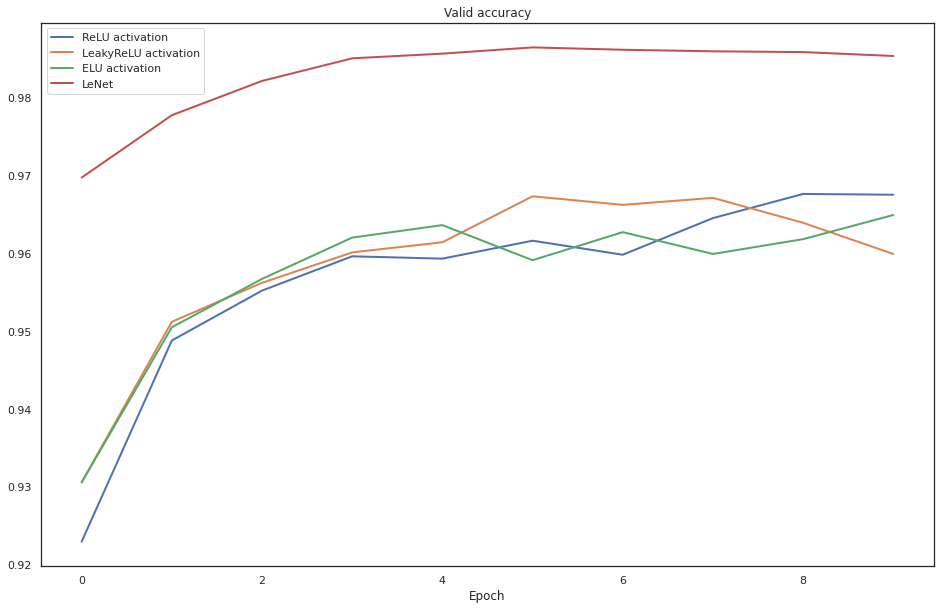

In [46]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:**

In [47]:
0.99

0.99